In [31]:
!pip install duckdb
!pip install matplotlib
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.9 MB/s eta 0:00:00


In [3]:
import duckdb
import pandas as pd

In [7]:
# Connect to DuckDB in memory
con = duckdb.connect(database=':memory:')

# Load all required CSVs as DuckDB tables
con.execute("CREATE TABLE prescriptions AS SELECT * FROM read_csv_auto('PRESCRIPTIONS.csv');")
con.execute("CREATE TABLE patients AS SELECT * FROM read_csv_auto('PATIENTS.csv');")
con.execute("CREATE TABLE icustays AS SELECT * FROM read_csv_auto('ICUSTAYS.csv');")
con.execute("CREATE TABLE procedures_icd AS SELECT * FROM read_csv_auto('PROCEDURES_ICD.csv');")
con.execute("CREATE TABLE d_icd_procedures AS SELECT * FROM read_csv_auto('D_ICD_PROCEDURES.csv');")
con.execute("CREATE TABLE drgcodes AS SELECT * FROM read_csv_auto('DRGCODES.csv');")
con.execute("CREATE TABLE admissions AS SELECT * FROM read_csv_auto('ADMISSIONS.csv');")


In [8]:
con.execute("SHOW TABLES").df()

,name
0,admissions
1,d_icd_procedures
2,drgcodes
3,icustays
4,patients
5,prescriptions
6,procedures_icd


In [12]:
con.execute("""
SELECT 
    a.ethnicity,
    pr.drug,
    COUNT(*) AS times_prescribed
FROM prescriptions pr
JOIN admissions a ON pr.subject_id = a.subject_id
GROUP BY a.ethnicity, pr.drug
ORDER BY a.ethnicity, times_prescribed DESC;
""").df()

,ethnicity,drug,times_prescribed
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,54
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,0.9% Sodium Chloride,44
2,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Potassium Chloride,42
3,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Lactulose,26
4,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Albumin 25% (12.5g / 50mL),22
...,...,...,...
1255,WHITE,Namenda,1
1256,WHITE,Ny,1
1257,WHITE,Theophylline (Oral Solution),1
1258,WHITE,Soln.,1


In [13]:
# Question 1
con.execute("""
SELECT ethnicity, drug, times_prescribed
FROM (
    SELECT 
        a.ethnicity,
        pr.drug,
        COUNT(*) AS times_prescribed,
        ROW_NUMBER() OVER (PARTITION BY a.ethnicity ORDER BY COUNT(*) DESC) AS rn
    FROM prescriptions pr
    JOIN admissions a ON pr.subject_id = a.subject_id
    GROUP BY a.ethnicity, pr.drug
)
WHERE rn = 1;
""").df()

,ethnicity,drug,times_prescribed
0,HISPANIC/LATINO - PUERTO RICAN,0.9% Sodium Chloride,1290
1,WHITE,Potassium Chloride,508
2,UNABLE TO OBTAIN,0.9% Sodium Chloride,28
3,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,54
4,OTHER,NS,11
5,BLACK/AFRICAN AMERICAN,Insulin,60
6,HISPANIC OR LATINO,5% Dextrose,28
7,ASIAN,D5W,27
8,UNKNOWN/NOT SPECIFIED,D5W,41


In [16]:
'''
I joined prescriptions and admissions on subject_id to associate each prescription with a patient's ethnicity. 
Then, the results were grouped by ethnicity and drug name, and how often each drug was prescribed was counted. 
A window function extracted only the top drug per ethnicity group.
'''

"\nI joined prescriptions and admissions on subject_id to associate each prescription with a patient's ethnicity. \nThen, the results were grouped by ethnicity and drug name, and how often each drug was prescribed was counted. \nA window function extracted only the top drug per ethnicity group.\n"

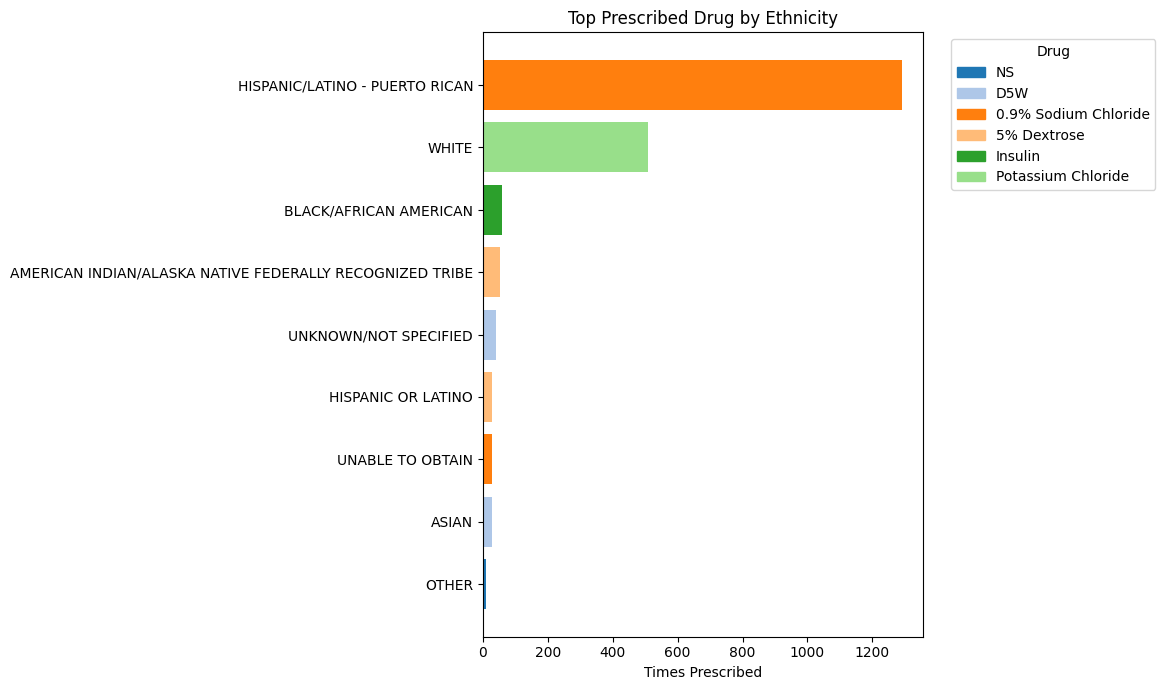

In [21]:
import matplotlib.pyplot as plt

# Run query again
top_drugs_df = con.execute("""
SELECT ethnicity, drug, times_prescribed
FROM (
    SELECT 
        a.ethnicity,
        pr.drug,
        COUNT(*) AS times_prescribed,
        ROW_NUMBER() OVER (PARTITION BY a.ethnicity ORDER BY COUNT(*) DESC) AS rn
    FROM prescriptions pr
    JOIN admissions a ON pr.subject_id = a.subject_id
    GROUP BY a.ethnicity, pr.drug
)
WHERE rn = 1;
""").df()

# Sort for clean visuals
top_drugs_df = top_drugs_df.sort_values("times_prescribed", ascending=True)

# Assign color per drug
unique_drugs = top_drugs_df['drug'].unique()
color_map = {drug: plt.cm.tab20(i) for i, drug in enumerate(unique_drugs)}
colors = top_drugs_df['drug'].map(color_map)

# Plot without text labels
plt.figure(figsize=(12, 7))
plt.barh(top_drugs_df['ethnicity'], top_drugs_df['times_prescribed'], color=colors)

# Add legend
handles = [plt.Rectangle((0,0),1,1, color=color_map[drug]) for drug in unique_drugs]
plt.legend(handles, unique_drugs, title="Drug", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Times Prescribed")
plt.title("Top Prescribed Drug by Ethnicity")
plt.tight_layout()
plt.show()

In [ ]:
'''
Findings Explained:
Most of the top-prescribed drugs are intravenous fluids used to treat dehydration or maintain fluid balance, 
such as normal saline (NS), D5W, and 5% dextrose. Potassium chloride is commonly given to correct low potassium levels, 
which is vital for heart and muscle function. Insulin is prescribed to manage high blood sugar, especially in patients 
with diabetes. The most commonly prescribed drugs skew towards the most common illnesses, which makes a lot of sense.
Despite ethnic diversity, the treatment patterns are strikingly similar. This could indicate that these drugs are first-line 
Interventions for common hospital conditions like dehydration, shock, or medication infusion. This could be showing us the 
baseline standard of care. I also noticed Black/African American patients had insulin as their top prescribed drug. 
This reflects well-documented disparities in diabetes prevalence and management needs in this population, emphasizing the 
intersection of chronic disease trends with prescription patterns. This, to me, was an important stand out in the data.
The presence of categories like “UNKNOWN/NOT SPECIFIED” and “UNABLE TO OBTAIN” may point to gaps in demographic recording and
this could theoretically limit the reliability of our findings.
'''

In [27]:
# Question 2

con.execute("""
SELECT 
  CASE
    WHEN DATE_DIFF('year', p.dob, a.admittime) <= 19 THEN '<=19'
    WHEN DATE_DIFF('year', p.dob, a.admittime) <= 49 THEN '20-49'
    WHEN DATE_DIFF('year', p.dob, a.admittime) <= 79 THEN '50-79'
    ELSE '80+'
  END AS age_group,
  d.short_title AS procedure_name,
  COUNT(*) AS procedure_count
FROM procedures_icd picd
JOIN admissions a ON picd.hadm_id = a.hadm_id
JOIN patients p ON a.subject_id = p.subject_id
JOIN d_icd_procedures d ON picd.icd9_code = d.icd9_code
GROUP BY age_group, procedure_name
QUALIFY ROW_NUMBER() OVER (PARTITION BY age_group ORDER BY COUNT(*) DESC) <= 3
""").df()

,age_group,procedure_name,procedure_count
0,<=19,Venous cath NEC,2
1,<=19,Vertebral fx repair,1
2,<=19,Interruption vena cava,1
3,50-79,Venous cath NEC,25
4,50-79,Entral infus nutrit sub,22
5,50-79,Packed cell transfusion,13
6,80+,Venous cath NEC,20
7,80+,Packed cell transfusion,13
8,80+,Insert endotracheal tube,8
9,20-49,Venous cath NEC,9


In [29]:
'''
Query Explanation:
This query identifies the top 3 most common medical procedures performed within each age group of patients. 
Age is calculated at the time of hospital admission using the DATE_DIFF function on the patient's date of birth 
and the admission time. Patients are grouped into four bins: <=19, 20–49, 50–79, and 80+. The query joins clinical 
procedure records with demographic and procedural description tables to retrieve the readable names. It then 
counts how often each procedure was performed per group and uses ROW_NUMBER with QUALIFY to return only the top 3 
procedures for each age group.
'''

"\nQuery Explanation:\nThis query identifies the top 3 most common medical procedures performed within each age group of patients. \nAge is calculated at the time of hospital admission using the DATE_DIFF function on the patient's date of birth \nand the admission time. Patients are grouped into four bins: <=19, 20–49, 50–79, and 80+. The query joins clinical \nprocedure records with demographic and procedural description tables to retrieve the readable names. It then \ncounts how often each procedure was performed per group and uses ROW_NUMBER with QUALIFY to return only the top 3 \nprocedures for each age group.\n"

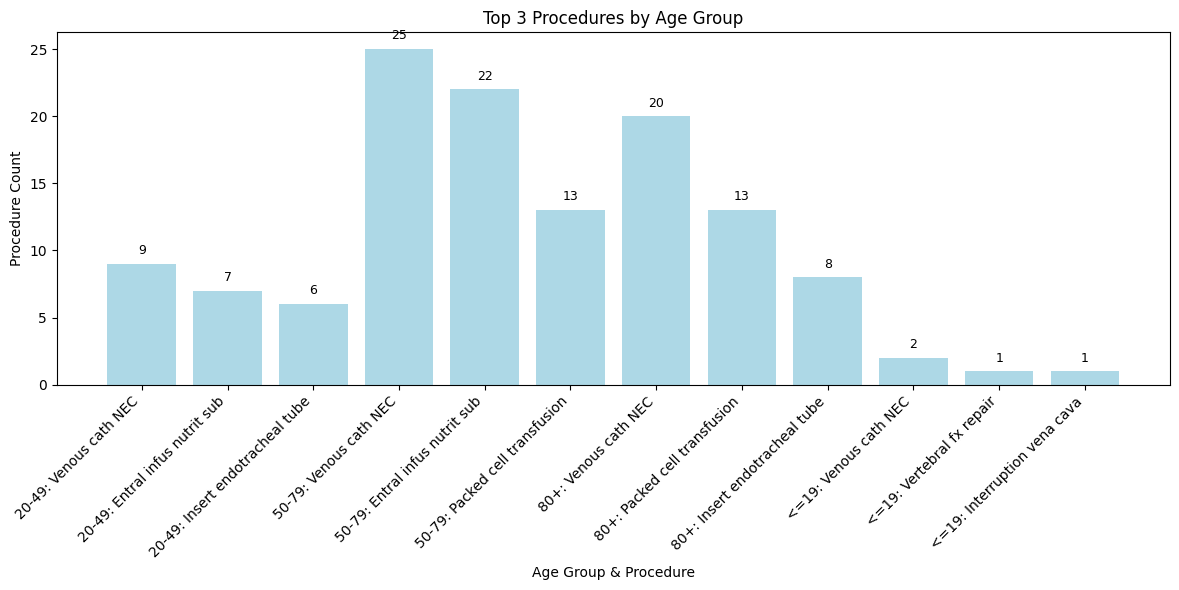

In [33]:
import matplotlib.pyplot as plt

# Run your query
df = con.execute("""
SELECT 
  CASE
    WHEN DATE_DIFF('year', p.dob, a.admittime) <= 19 THEN '<=19'
    WHEN DATE_DIFF('year', p.dob, a.admittime) <= 49 THEN '20-49'
    WHEN DATE_DIFF('year', p.dob, a.admittime) <= 79 THEN '50-79'
    ELSE '80+'
  END AS age_group,
  d.short_title AS procedure_name,
  COUNT(*) AS procedure_count
FROM procedures_icd picd
JOIN admissions a ON picd.hadm_id = a.hadm_id
JOIN patients p ON a.subject_id = p.subject_id
JOIN d_icd_procedures d ON picd.icd9_code = d.icd9_code
GROUP BY age_group, procedure_name
QUALIFY ROW_NUMBER() OVER (PARTITION BY age_group ORDER BY COUNT(*) DESC) <= 3
""").df()

# Sort for consistent bar order
df = df.sort_values(by=["age_group", "procedure_count"], ascending=[True, False])

# Create labels with age group and procedure
df["label"] = df["age_group"] + ": " + df["procedure_name"]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(df["label"], df["procedure_count"], color="lightblue")

# Add bar labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, int(height), ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Age Group & Procedure")
plt.ylabel("Procedure Count")
plt.title("Top 3 Procedures by Age Group")
plt.tight_layout()
plt.show()

In [35]:
'''
Findings Summarized:
The chart shows the top three most common procedures performed for each age group. Across the 50–79 and 80+ age 
ranges, procedures like venous catheter placement, enteral nutrition infusion, and packed cell transfusion dominate, 
indicating a higher need for vascular access and nutritional or blood support in older patients. In contrast, younger 
patients (<=19) have far fewer recorded procedures overall, with a steep drop in counts, suggesting they undergo 
fewer invasive interventions. The 20–49 age group shows some overlap with older groups in terms of procedure types but 
at lower frequencies. These trends reflect the increasing medical complexity and support needs that come with age.
'''

'\nFindings Summarized:\nThe chart shows the top three most common procedures performed for each age group. Across the 50–79 and 80+ age \nranges, procedures like venous catheter placement, enteral nutrition infusion, and packed cell transfusion dominate, \nindicating a higher need for vascular access and nutritional or blood support in older patients. In contrast, younger \npatients (<=19) have far fewer recorded procedures overall, with a steep drop in counts, suggesting they undergo \nfewer invasive interventions. The 20–49 age group shows some overlap with older groups in terms of procedure types but \nat lower frequencies. These trends reflect the increasing medical complexity and support needs that come with age.\n'

In [42]:
# Question 3
con.execute("""
SELECT 
  a.admission_type,
  ROUND(AVG(i.los), 2) AS avg_icu_los_days
FROM icustays i
JOIN admissions a ON i.hadm_id = a.hadm_id
WHERE i.los IS NOT NULL
GROUP BY a.admission_type
ORDER BY avg_icu_los_days DESC
""").df()

,admission_type,avg_icu_los_days
0,URGENT,5.21
1,EMERGENCY,4.53
2,ELECTIVE,3.01


In [46]:
con.execute("""
SELECT 
  p.gender,
  ROUND(AVG(i.los), 2) AS avg_icu_los_days,
  COUNT(*) AS num_cases
FROM icustays i
JOIN admissions a ON i.hadm_id = a.hadm_id
JOIN patients p ON a.subject_id = p.subject_id
WHERE i.intime IS NOT NULL AND i.outtime IS NOT NULL
GROUP BY p.gender
ORDER BY avg_icu_los_days DESC
""").df()

,gender,avg_icu_los_days,num_cases
0,F,5.54,63
1,M,3.51,73


In [47]:
con.execute("""
SELECT 
  a.ethnicity,
  ROUND(AVG(i.los), 2) AS avg_icu_los_days,
  COUNT(*) AS num_cases
FROM icustays i
JOIN admissions a ON i.hadm_id = a.hadm_id
WHERE i.intime IS NOT NULL AND i.outtime IS NOT NULL
GROUP BY a.ethnicity
ORDER BY avg_icu_los_days DESC
""").df()

,ethnicity,avg_icu_los_days,num_cases
0,UNABLE TO OBTAIN,13.36,1
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,11.34,2
2,BLACK/AFRICAN AMERICAN,7.68,7
3,HISPANIC OR LATINO,7.46,3
4,UNKNOWN/NOT SPECIFIED,4.93,11
5,WHITE,4.13,92
6,ASIAN,3.89,2
7,HISPANIC/LATINO - PUERTO RICAN,3.24,15
8,OTHER,0.93,3


In [ ]:
'''
Queries explained:
Query 1: This query calculates the average ICU length of stay (LOS) in days for each hospital admission type 
(EMERGENCY, URGENT, ELECTIVE). It uses the los (length of stay) column from the icustays table and joins it with 
the admissions table to group by admission_type. It also includes a count of how many cases fall into each group.

Query 2: This query computes the average ICU LOS by gender (M or F). It joins icustays, admissions, and patients 
tables and filters for non-null intime and outtime values. The result shows both the average stay duration and the 
total number of ICU cases per gender.

Query 3: This query finds the average ICU LOS grouped by patient ethnicity (from the admissions table). It also 
counts the number of cases per ethnicity. This helps identify disparities in ICU stay durations across different 
ethnic groups.

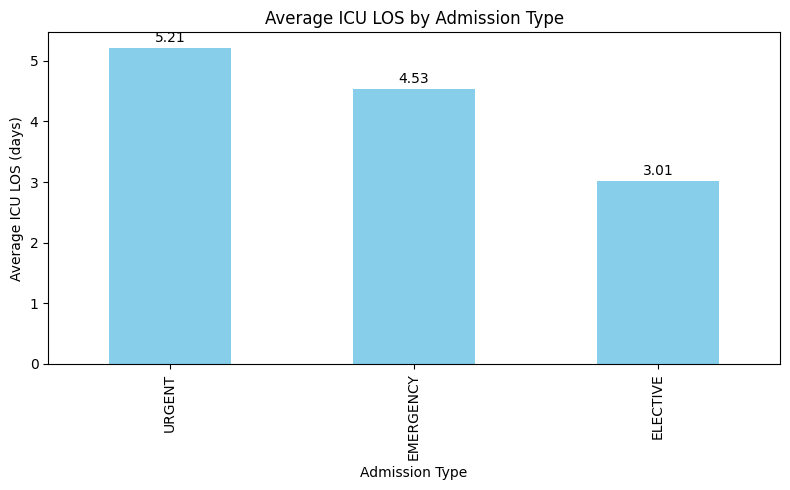

In [48]:
df_admission = con.execute("""
SELECT 
  a.admission_type,
  ROUND(AVG(i.los), 2) AS avg_icu_los_days
FROM icustays i
JOIN admissions a ON i.hadm_id = a.hadm_id
WHERE i.los IS NOT NULL
GROUP BY a.admission_type
ORDER BY avg_icu_los_days DESC
""").df()

# Assuming df_admission is your DataFrame from the first query
df_admission.plot.bar(
    x='admission_type', 
    y='avg_icu_los_days', 
    legend=False, 
    color='skyblue',
    figsize=(8, 5)
)
plt.title("Average ICU LOS by Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Average ICU LOS (days)")

# Add value labels
for idx, val in enumerate(df_admission['avg_icu_los_days']):
    plt.text(idx, val + 0.1, str(val), ha='center')

plt.tight_layout()
plt.show()

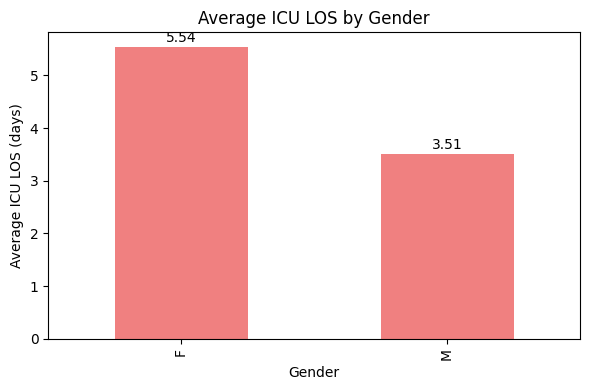

In [49]:
df_gender = con.execute("""
SELECT 
  p.gender,
  ROUND(AVG(i.los), 2) AS avg_icu_los_days,
  COUNT(*) AS num_cases
FROM icustays i
JOIN admissions a ON i.hadm_id = a.hadm_id
JOIN patients p ON a.subject_id = p.subject_id
WHERE i.intime IS NOT NULL AND i.outtime IS NOT NULL
GROUP BY p.gender
ORDER BY avg_icu_los_days DESC
""").df()

df_gender.plot.bar(
    x='gender', 
    y='avg_icu_los_days', 
    legend=False, 
    color='lightcoral',
    figsize=(6, 4)
)
plt.title("Average ICU LOS by Gender")
plt.xlabel("Gender")
plt.ylabel("Average ICU LOS (days)")

for idx, val in enumerate(df_gender['avg_icu_los_days']):
    plt.text(idx, val + 0.1, str(val), ha='center')

plt.tight_layout()
plt.show()


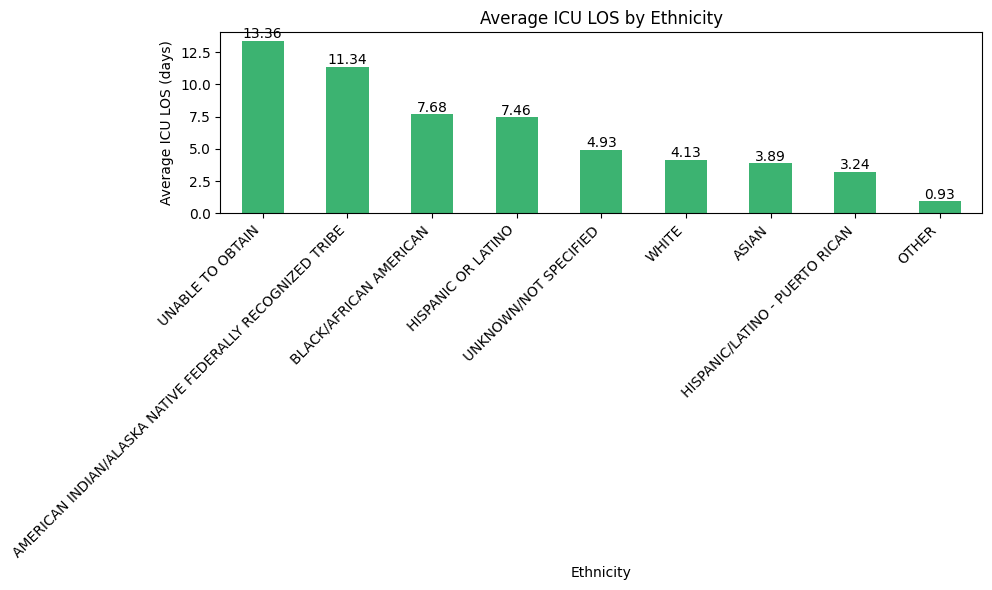

In [50]:
df_ethnicity = con.execute("""
SELECT 
  a.ethnicity,
  ROUND(AVG(i.los), 2) AS avg_icu_los_days,
  COUNT(*) AS num_cases
FROM icustays i
JOIN admissions a ON i.hadm_id = a.hadm_id
WHERE i.intime IS NOT NULL AND i.outtime IS NOT NULL
GROUP BY a.ethnicity
ORDER BY avg_icu_los_days DESC
""").df()

df_ethnicity.plot.bar(
    x='ethnicity', 
    y='avg_icu_los_days', 
    legend=False, 
    color='mediumseagreen',
    figsize=(10, 6)
)
plt.title("Average ICU LOS by Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Average ICU LOS (days)")

# Rotate x labels for readability
plt.xticks(rotation=45, ha='right')

for idx, val in enumerate(df_ethnicity['avg_icu_los_days']):
    plt.text(idx, val + 0.2, str(val), ha='center')

plt.tight_layout()
plt.show()


In [ ]:
'''
Findings Analyzed:
Query 1: The chart shows that ICU patients admitted under urgent conditions have the longest average length of stay 
(5.21 days), followed by those admitted under emergency conditions (4.53 days), and lastly elective admissions 
(3.01 days). This trend aligns with clinical expectations: urgent cases often involve more complex, time-sensitive health 
issues requiring prolonged care, while elective admissions are typically scheduled procedures with more predictable recovery 
paths, resulting in shorter ICU stays.

Query 2: The chart reveals that female patients have a notably longer average ICU length of stay (5.54 days) compared to 
male patients (3.51 days). One plausible factor could be the inclusion of pregnancy-related or labor-related ICU admissions, 
which are specific to females and can involve complex, high-risk scenarios requiring extended monitoring and care. Additionally, 
it may reflect differences in baseline health status, treatment response, or care pathways between genders. However, further 
investigation would be needed to confirm the specific causes behind this disparity.

Query 3: This chart shows variation in average ICU length of stay (LOS) across different ethnic groups, but it's important 
to interpret these results with caution due to the small sample sizes in many categories. For example, the highest average 
LOS values—like 13.36 days for "UNABLE TO OBTAIN" and 11.34 days for "AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE"
—are based on only one or two cases, which limits their reliability. In contrast, groups like "WHITE" and "HISPANIC/LATINO - 
PUERTO RICAN" have much larger sample sizes (e.g., 92 and 15 cases), making their average LOS figures more representative. 
These disparities highlight the importance of considering both magnitude and statistical weight when analyzing healthcare outcomes.
I would say it is important to take all these results with a grain of salt, because besides the category with 92 samples, I am not
convinced that any of the other sizes are large enough to draw any thoughtful conclusions.
'''